In [12]:
import numpy as np
import pandas as pd
import yfinance as yf
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import time
from scipy import stats
from scipy.stats import norm
from scipy.stats import shapiro
from scipy.optimize import brentq
from scipy.integrate import quad
from scipy.optimize import minimize
from numpy.polynomial.laguerre import laggauss



from dateutil import parser
from dateutil.tz import tzutc

sns.set_style('darkgrid')

## **Option Terminology**
**Premium**: The price paid by the option buyer to the option seller for obtaining the right. It represents the cost of the option.

**Strike Price**: The predetermined price at which the underlying asset can be bought or sold.

**Expiration Date**: The date when the option contract expires. After this date, the option is no longer valid.

**Time to Expiration**: The amount of time in years to contract expiration date.

**In-the-Money (ITM)**: For a call option, when the market price is above the strike price. For a put option, when the market price is below the strike price.

**Out-of-the-Money (OTM)**: For a call option, when the market price is below the strike price. For a put option, when the market price is above the strike price.

**At-the-Money (ATM)**: When the market price is equal to the strike price.
Spot Price/Asset Price: Price of the underlying asset.

# **European Options**

A **(European) call option** is a contract between two parties, a buyer and a seller, that gives the buyer the right, but not the obligation, **to buy an underlying asset** from the seller for a predetermined price
$K$, called the strike price at a future point of time.

A *(European) put option* is a contract between two parties, a buyer and a seller, that gives the buyer the right, but not the obligation, **to sell an underlying asset** to the seller for a predetermined price $K$, called the strike price at a future point of time.



# **Fair Market Price of an Option Contract**
Let $S_t$ denote the value of a stock at a time $t$. Consider a call option on the stock with strike price $K$ that expires at time $t$. The value of the call option at the expiration time $t$ is $$\max(S_t - K, 0)$$

The **fair market value** of the call option at time $0$ is the expected value of $\max(S_t - K, 0)$, discounted to time $0$, i.e.,
$$C_0 = e^{-rt}\mathbb{E}[\max(S_t - K, 0)]$$

Similarly, consider a put option on the stock with strike price $K$ that expires at time $t$. The value of the put option at the expiration time $t$ is
$$\max(K - S_t, 0)$$

The fair market value of the put option at time $0$ is the expected value of
$$\max(K - S_t, 0)$$ discounted to time $0$, i.e., $$P_0 = e^{-rt}\mathbb{E}[\max(K - S_t, 0)]$$

## **Put-Call Parity**
The prices of put and call options respect the put-call parity formula, i.e.
$$P_0 - C_0 = Ke^{-rt} - S_0$$

## **Option pricing via Monte-Carlo Methods**
It we assume a model of stock prices $S_t$, then we can use Monte-Carlo methods to estimate the values $C_0 = e^{-rt}\mathbb{E}[\max(S_t - K, 0)]$
and $P_0 = e^{-rt}\mathbb{E}[\max(K - S_t, 0)]$


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


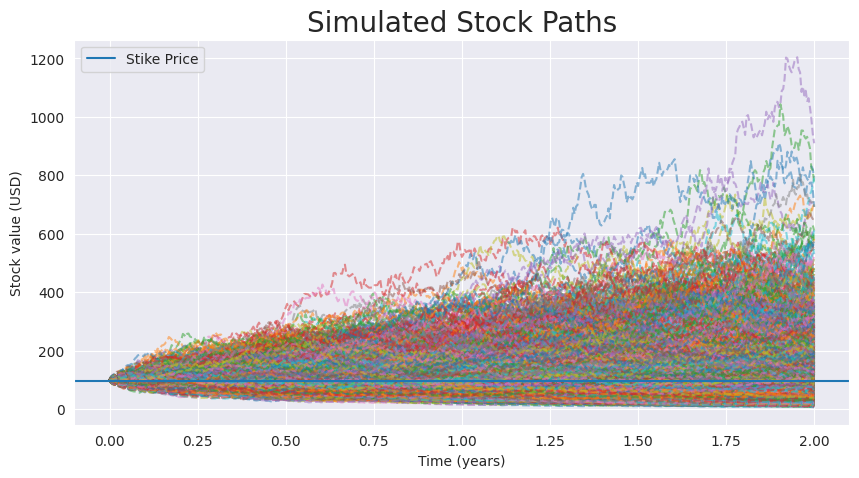

Estimated call value (discounted to time 0): $29.12
Estimated put value (discounted to time 0): $18.20
P - C: $-10.92
K*e^0.07 - S: $-11.42


In [13]:
## Randomly generated stock paths as Geometric Brownian Motions

def GBM_paths(S0, sigma, t, r, mu, n_sims, n_steps):
    """Simulates stock paths as geometric Brownian Motions
    Inputs:
    S0 (float): Underlying stock price at time 0
    sigma (float): Yearly volatility
    t (float): Time to expiration (years)
    r (float): Risk-free interest rate
    mu (float): Drift of log-returns
    n_sims (int): Number of simulated paths
    n_steps (int): Number of steps in each simulated path, each step interval has length t/n_steps

    Return (np.array): Array of stock paths
    """

    dt = t/n_steps
    noise = np.random.normal(loc = 0, scale = 1, size = (n_sims, n_steps))
    log_returns = (mu+r-sigma**2*(0.5))*dt + sigma*np.sqrt(dt)*noise;
    exponent = np.cumsum(log_returns, axis = 1)
    paths = S0*np.exp(exponent)
    paths_with_start = np.insert(paths, 0, S0, axis = 1)

    return paths_with_start

S0 = 100

sigma = .45

t = 2

r = .035

mu = 0 #mu =0 represents the risk-free stock-path model

n_sims = 10000

n_steps = 500


time = np.linspace(0, t, n_steps + 1)

stock_paths = GBM_paths(S0, sigma, t, r, mu, n_sims, n_steps)


K = 95

plt.figure(figsize = (10,5))
for path in stock_paths:

    plt.plot(time, path, alpha = .5, ls = '--')




plt.axhline(K, label = 'Stike Price')



plt.xlabel('Time (years)')
plt.ylabel('Stock value (USD)')
plt.title('Simulated Stock Paths', size = 20)

plt.legend()
plt.show()


path_endpoints = stock_paths[:,-1]

call_values = np.maximum(path_endpoints-K, 0)

put_values = np.maximum(K - path_endpoints, 0)

call_values_discounted = np.exp(-r*t)*call_values

put_values_discounted = np.exp(-r*t)*put_values

call_value_estimate = np.mean(call_values_discounted)

put_value_estimate = np.mean(put_values_discounted)

print(f'Estimated call value (discounted to time 0): ${call_value_estimate:.2f}')

print(f'Estimated put value (discounted to time 0): ${put_value_estimate:.2f}')

print(f'P - C: ${put_value_estimate - call_value_estimate:.2f}')

print(f'K*e^{r*t} - S: ${K*np.exp(-r*t) - S0:.2f}')


# **Black-Scholes Equation for Call and Put Options**
Let $t > 0$ and assume the distribution of stock prices $S_t$ from time $0$ to time $t$ is the risk-free Geometric Brownian Motion model:
$$S_t = S_0e^{\big(r - \frac{\sigma^2}{2}\big)t + \sigma \sqrt{t}\mathcal{N}(0, 1)},$$
where:

$S_0$ is the stock price at time $0$;

$\sigma$ the is yearly standard deviation of log-returns;

$r$ is the risk-free interest rate;

$\mathcal{N}(0, 1)$ is the standard normal distribution;

Let $\varphi$ and $\Phi$ denote the probability density function (PDF) and cumulative distribution function (CDF) of the standard normal distribution respectively:

$$\varphi(x) = \frac{e^{-x^2}}{2} \text{ and } \Phi(y) = \mathbb{P}\big(\mathcal{N}(0, 1) \le y\big) = \int_{-\infty}^{y} \varphi(x) \,dx$$

Let $K > 0$ be a strike price. Denote by $C_t = \max(S_t - K, 0)$ and $P_t = \max(K - S_t, 0)$ the distriubtion of respective values of a call and a put option at expiration time $t$. Let
$$C_0 = e^{-rt}\mathbb{E}[\max(S_t - K, 0)] \text{ and } P_0 = e^{-rt}\mathbb{E}[\max(K - S_t, 0)]$$
be the discounted to time $0$ expected values of $C_t$ and $P_t$ respectively. Then
$$C_0 = S_0 \Phi(d_1) - Ke^{-rt}\Phi(d_2) \text{ and } P_0 = -S_0 \Phi(-d_1) + Ke^{-rt}\Phi(-d_2),$$
where
$$d_1 = \frac{\ln\big(S_0/K) + (r + σ^2/2)t}{σ \sqrt{t}} \text{ and } d_2 = d_1 - σ \sqrt{t}$$
Note that the probabilities that the options expire in the money are the following:
$$\mathbb{P}[C_t > 0 ] = \Phi(d_2) \text{ and } \mathbb{P}[P_t > 0] = \Phi(-d_2)$$
Moreover, they satisfy
$$S_0 \varphi(d_1) = e^{-rt}\phi(d_2)$$

# **Delta**
The **delta** of an option is the rate of change of the Black-Scholes price of the option with respect to the price of the underlying stock price $S_0$:
$$Δ_{C_0} := \frac{\partial C_0}{\partial S_0} = \Phi(d_1), Δ_{P_0} := \frac{\partial P_0}{\partial S_0} = -1 + \Phi(d_1)$$

# **Vega**
The **vega of an option is the rate of change of the Black-Scholes price of the option with respect to volatility $\sigma$:
$$\nu_{C_0} = \nu_{P_0} := \frac{\partial C_0}{\partial \sigma} = S_0 \varphi(d_1)\sqrt{t} = e^{-rt}K\varphi(d_2)\sqrt{t}$$

# **Remark:**

The above formulas assume that option prices can be determined using a risk-neutral valuation framework. This assumption can be justified under the following assumptions:

* A trader can continuously buy and sell fractional shares of the stock to construct a dynamic hedging portfolio that replicates the option payoff.
* There are no transaction costs or bid-ask spreads.

Moreover, Black-Scholes assumes the following about a stock-path:

* a stock path has log-normal returns and log-returns over a period of time are independent of log-returns over a previous time;

* Log-returns are normally distributed;

* Volatility is constant;

In [14]:
##Black-Scholes Functions
def bs_call(S0, K, sigma, t, r):
    '''
    Black-Scholes Call Option formula

    Inputs:
    S0 (float): Stock price at time 0
    K (float): Strike Price
    sigma: Yearly volatility
    t: Time to expiration (years)
    r: Risk-free Interest rate


    Return:
    Black-Scholes value of call option (float)
    '''

    d1 = (np.log(S0/K) + (r + (0.5)*sigma**2)*t)/(sigma*np.sqrt(t))

    d2 = d1 - sigma*np.sqrt(t)


    call_value = S0*norm.cdf(d1) - K*np.exp(-r*t)*norm.cdf(d2)


    return call_value



def bs_put(S0, K, sigma, t, r):
    '''
    Black-Scholes Put Option formula

    Inputs:
    S0 (float): Stock price at time 0
    K (float): Strike Price
    sigma: Yearly volatility
    t: Time to expiration (years)
    r: Risk-free Interest rate


    Return:
    Black-Scholes value of put option (float)
    '''

    d1 = (np.log(S0/K) + (r + (0.5)*sigma**2)*t)/(sigma*np.sqrt(t))

    d2 = d1 - sigma*np.sqrt(t)


    put_value = -S0*norm.cdf(-d1) + K*np.exp(-r*t)*norm.cdf(-d2)


    return put_value


def bs_call_delta(S0, K, sigma, t, r):
    '''Black-Scholes Delta of Call Option

    Inputs:
    S0 (float): Stock price at time 0
    K (float): Strike Price
    sigma: Yearly volatility
    t: Time to expiration (years)
    r: Risk-free Interest rate


    Return:
    Black-Scholes rate of change of call option with respect to S_0

    '''


    d1 = (np.log(S0/K) + (r + (0.5)*sigma**2)*t)/(sigma*np.sqrt(t))


    return norm.cdf(d1)



def bs_put_delta(S0, K, sigma, t, r):
    '''Black-Scholes Delta of Put Option

    Inputs:
    S0 (float): Stock price at time 0
    K (float): Strike Price
    sigma: Yearly volatility
    t: Time to expiration (years)
    r: Risk-free Interest rate


    Return:
    Black-Scholes rate of change of put option with respect to S_0

    '''
    d1 = (np.log(S0/K) + (r + (0.5)*sigma**2)*t)/(sigma*np.sqrt(t))


    return -1 + norm.cdf(d1)


def bs_vega(S0, K, sigma, t, r):
    '''Black-Scholes vega of Call & Put Options

    Inputs:
    S0 (float): Stock price at time 0
    K (float): Strike Price
    sigma: Yearly volatility
    t: Time to expiration (years)
    r: Risk-free Interest rate


    Return:
    Black-Scholes rate of change of call & put option with respect to sigma

    '''

    d1 = (np.log(S0/K) + (r + (0.5)*sigma**2)*t)/(sigma*np.sqrt(t))


    return S0*norm.pdf(d1)*np.sqrt(t)




## **Hedging**
The process of hedging an option, from a market-makers point of view, is the process of selling option contracts, and then buying and selling the underlying stock over the interval of time to expiration, and is done so to neutralize the risk of big losses and to protect profits obtained from the premium gathered from selling options.

[*********************100%***********************]  8 of 8 completed


Running AAPL...
Running AMZN...
Running GOOGL...
Running META...
Running MSFT...
Running NVDA...
Running TSLA...
Running SPY...
          mean    std  count  Sharpe
Ticker                              
AAPL    4.3208 1.1858     24  3.6436
AMZN    3.6280 1.4570     24  2.4901
GOOGL   3.2873 1.2093     24  2.7184
META    8.3868 4.6165     24  1.8167
MSFT    8.5650 3.0921     24  2.7700
NVDA    1.5252 1.1567     24  1.3186
SPY    12.1199 3.4460     24  3.5171
TSLA    6.0099 4.4565     24  1.3486


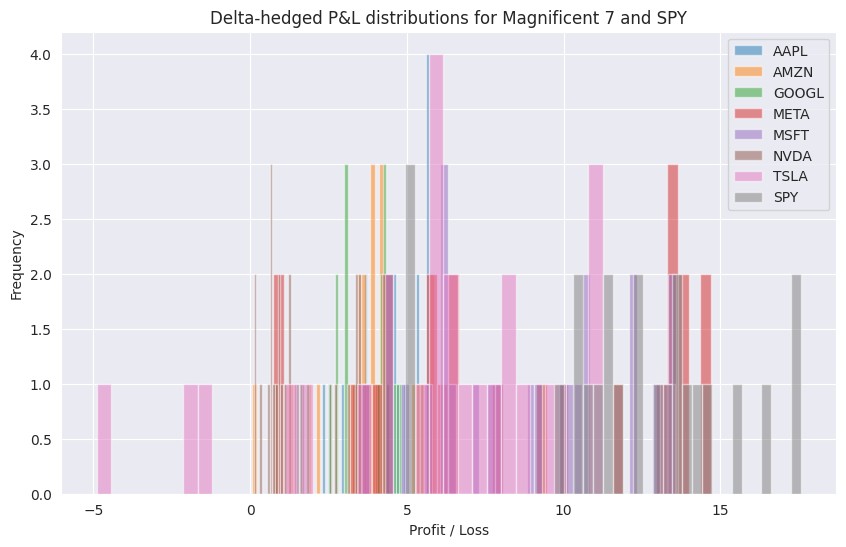

In [15]:
# --- Parameters ---
tickers = ["AAPL", "AMZN", "GOOGL", "META", "MSFT", "NVDA", "TSLA", "SPY"]
r = 0.035
window = 252

data = yf.download(tickers, start="2022-01-01", end="2025-01-01", auto_adjust=True)
data_close = data["Close"]
returns = np.log(data_close / data_close.shift(1))
realized_vol = returns.rolling(window).std() * np.sqrt(252)

# --- Hedging function ---
def hedge_on_historical_path(prices, K, sigma_real, sigma_model, r):
    n_steps = len(prices) - 1
    T = 1
    times = np.linspace(0, T, n_steps + 1)
    S = prices.values
    deltas = np.zeros(n_steps + 1)
    for j in range(n_steps + 1):
        tau = T - times[j]
        if tau == 0:
            tau = 1e-8
        deltas[j] = bs_call_delta(S[j], K, sigma_model, tau, r)
    stock_changes = S[1:] - S[:-1]
    stock_profits = deltas[:-1] * stock_changes
    discount_factors = np.exp(-r * times[1:])
    total_stock_profits = np.sum(stock_profits * discount_factors)
    call_payout_discounted = max(S[-1] - K, 0) * np.exp(-r * T)
    premium = bs_call(S[0], K, sigma_model, T, r)
    pnl = premium + total_stock_profits - call_payout_discounted
    return pnl

results = []
for ticker in tickers:
    print(f"Running {ticker}...")
    series = data_close[ticker].dropna()
    realized_vol_series = realized_vol[ticker]
    for i in range(252, len(series) - 1, 21):
        sigma_real = realized_vol_series.iloc[i]
        if np.isnan(sigma_real) or sigma_real <= 0:
            continue
        window_prices = series.iloc[i - 252 : i + 1]
        sigma_model = sigma_real + 0.01 #can change the 0.01, this just says how much more the price of the option is in the market
        K = window_prices.iloc[0]
        pnl = hedge_on_historical_path(window_prices, K, sigma_real, sigma_model, r)
        results.append({
            "Ticker": ticker,
            "StartDate": window_prices.index[0],
            "EndDate": window_prices.index[-1],
            "SigmaReal": sigma_real,
            "SigmaModel": sigma_model,
            "PnL": pnl
        })

df_results = pd.DataFrame(results)
summary = df_results.groupby("Ticker")["PnL"].agg(["mean", "std", "count"])
summary["Sharpe"] = summary["mean"] / summary["std"]
print(summary)

plt.figure(figsize=(10,6))
for ticker in tickers:
    subset = df_results[df_results["Ticker"] == ticker]
    plt.hist(subset["PnL"], bins=40, alpha=0.5, label=ticker)
plt.legend()
plt.title("Delta-hedged P&L distributions for Magnificent 7 and SPY")
plt.xlabel("Profit / Loss")
plt.ylabel("Frequency")
plt.show()

In [16]:
##Implied volatility functions
def implied_volatility_call(market_price, S0, K, t, r, sigma_bounds=(1e-6, 2)):
    def objective(sigma):
        return bs_call(S0, K, sigma, t, r) - market_price

    try:
        return brentq(objective, *sigma_bounds)
    except ValueError:
        return np.nan

def implied_volatility_put(market_price, S0, K, t, r, sigma_bounds=(1e-6, 2)):
    def objective(sigma):
        return bs_put(S0, K, sigma, t, r) - market_price

    try:
        return brentq(objective, *sigma_bounds)
    except ValueError:
        return np.nan



##Functions for option data obtained through y-finance
def find_tte_yf_options(expiration_date,last_trade_date):
    tte = (datetime.datetime.strptime(expiration_date+'-21-30', "%Y-%m-%d-%H-%M").replace(tzinfo=tzutc()) -\
last_trade_date).total_seconds()/(60*60*24*365)

    return tte


def yf_find_approx_spot(stock_data, last_trade_date):
    # Round timestamp to the minute (zero out seconds)
    ts = last_trade_date.replace(second=0)

    try:
        return stock_data.loc[ts].iloc[0]
    except KeyError:
        return float('nan')

## **The Heston Model**
The Heston model is a stochastic volatility model whose corresponding formula for option contracts naturally simulates the phenomena of v**olatility smiles** in market data. The Heston model for this reason is likely a more robust model for designing hedging stratigies for two reasons. The first, the Heston model naturally incoroporates autoregressive features of log-returns observed in markets. The second is that the Heston model can simulate option market prices and therefore is more likely to be a better method of simulating a portfolio's distribution of market value throughout the duration of managing an option portfolio.

## **The $n$-step discrete Heston Model:**
Let $0 = t_0 < t_1 < \ldots < t_n = t$, then the $n$-step discrete Heston model assumes for each $1 \le i \le n$, the variance of the log-returns at time $t_i$ is modeled as
$$\nu_{t_i} = \max(\nu_{t-1}, 0) + \kappa(\theta - \max(\nu_{t_{i-1}}, 0))(t_i - t_{i - 1}) + \xi(\sqrt{\max(\nu_{t-1}, 0)(t_i - t_{i - 1})}\mathcal{N}^{\nu}(0, 1)$$
and the distribution of stock paths from time $t_{i - 1}$ to $t_i$ is modeled as
$$S_{t_i} = S_{t_{i - 1}}e^{\mu + r - \max(\nu_{t_{i - 1}}, 0)(t_{i} - t_{i - 1})/2 + \xi(\sqrt{\max(\nu_{t-1}, 0)(t_i - t_{i - 1})}\mathcal{N}^{S}(0, 1)}$$
where
* $S_0$ is the initial stock price;

* $S_t$ is the stock price at time $t$;

* $\nu_0$ is the variance of the stock at time $0$;

* $\nu_t$ is the variance of the stock at time $t$;

* $\mu$ is the excess drift of the log-returns of the stock;

* $r$ is the risk-free interest rate;

* $\kappa$ is the mean-reversion rate of the variance process;

* $\theta$ is the long-run variance level of the variance process;

* $\xi$ is the volatility of volatility;

* $\mathcal{N}^{\nu}(0, 1)$ and $\mathcal{N}^S(0, 1)$ are standard normal distributions with correlation $\rho$;


# **Remark 1:**
The general definition of the Heston Model describes the variance and stock paths as being modeled as intertwined solutions to a system of stochastic Partial Differential Equations. The limiting distribution of variances and stock paths of the discrete models as the number of steps tends to $\infty$ is the continuous model described by the system of stochastic partial differential equations.

# **Remark 2:**
The Heston model is a generalization of the Black-Scholes/Geometric Brownian Motion Model. The two models agree if:


* $\nu = 0$;
* $\kappa = 0$;  
* $\xi = 0$;

# **Remark 3:**

Some realistic ranges of the parameters $\kappa, \xi, \rho$ for a Heston model are the following:


* $1 \le \kappa \le 5$;
* $0.2 \le \xi \le 1$;
* -0.9 \le \rho \le -0.2$;




In [17]:
## Heston functions using the characteristic function of the Heston model derived by Heston.

def heston_call(S0, K, v0, r, t, kappa, theta, xi, rho):

    def integrand(phi, Pnum):
        i = complex(0, 1)
        u = 0.5 if Pnum == 1 else -0.5
        b = kappa - rho * xi if Pnum == 1 else kappa
        a = kappa * theta
        d = np.sqrt((rho * xi * phi * i - b)**2 - xi**2 * (2 * u * phi * i - phi**2))
        g = (b - rho * xi * phi * i + d) / (b - rho * xi * phi * i - d)

        exp1 = np.exp(i * phi * np.log(S0 / K))
        C = r * phi * i * t + a / xi**2 * ((b - rho * xi * phi * i + d) * t - 2 * np.log((1 - g * np.exp(d * t)) / (1 - g)))
        D = (b - rho * xi * phi * i + d) / xi**2 * ((1 - np.exp(d * t)) / (1 - g * np.exp(d * t)))
        f = exp1 * np.exp(C + D * v0)
        return np.real(f / (phi * i))

    P1 = 0.5 + (1 / np.pi) * quad(lambda phi: integrand(phi, 1), 0, 100)[0]
    P2 = 0.5 + (1 / np.pi) * quad(lambda phi: integrand(phi, 2), 0, 100)[0]
    call_price = S0 * P1 - K * np.exp(-r * t) * P2
    return call_price


def heston_call_delta(S0, K, v0, r, t, kappa, theta, xi, rho):
    def integrand(phi, Pnum):
        i = complex(0, 1)
        u = 0.5 if Pnum == 1 else -0.5
        b = kappa - rho * xi if Pnum == 1 else kappa
        a = kappa * theta
        d = np.sqrt((rho * xi * phi * i - b)**2 - xi**2 * (2 * u * phi * i - phi**2))
        g = (b - rho * xi * phi * i + d) / (b - rho * xi * phi * i - d)

        exp1 = np.exp(i * phi * np.log(S0 / K))
        C = r * phi * i * t + a / xi**2 * ((b - rho * xi * phi * i + d) * t - 2 * np.log((1 - g * np.exp(d * t)) / (1 - g)))
        D = (b - rho * xi * phi * i + d) / xi**2 * ((1 - np.exp(d * t)) / (1 - g * np.exp(d * t)))
        f = exp1 * np.exp(C + D * v0)
        return np.real(f / (phi * i))

    P1 = 0.5 + (1 / np.pi) * quad(lambda phi: integrand(phi, 1), 0, 100)[0]
    return P1

def heston_put(S0, K, v0, r, t, kappa, theta, xi, rho):
    def integrand(phi, Pnum):
        i = complex(0, 1)
        u = 0.5 if Pnum == 1 else -0.5
        b = kappa - rho * xi if Pnum == 1 else kappa
        a = kappa * theta
        d = np.sqrt((rho * xi * phi * i - b)**2 - xi**2 * (2 * u * phi * i - phi**2))
        g = (b - rho * xi * phi * i + d) / (b - rho * xi * phi * i - d)

        exp1 = np.exp(i * phi * np.log(S0 / K))
        C = r * phi * i * t + a / xi**2 * ((b - rho * xi * phi * i + d) * t - 2 * np.log((1 - g * np.exp(d * t)) / (1 - g)))
        D = (b - rho * xi * phi * i + d) / xi**2 * ((1 - np.exp(d * t)) / (1 - g * np.exp(d * t)))
        f = exp1 * np.exp(C + D * v0)
        return np.real(f / (phi * i))

    P1 = 0.5 + (1 / np.pi) * quad(lambda phi: integrand(phi, 1), 0, 100)[0]
    P2 = 0.5 + (1 / np.pi) * quad(lambda phi: integrand(phi, 2), 0, 100)[0]

    call_price = S0 * P1 - K * np.exp(-r * t) * P2
    put_price = call_price - S0 + K * np.exp(-r * t)  # via put-call parity

    return put_price


def heston_put_delta(S0, K, v0, r, t, kappa, theta, xi, rho):
    def integrand(phi, Pnum):
        i = complex(0, 1)
        u = 0.5 if Pnum == 1 else -0.5
        b = kappa - rho * xi if Pnum == 1 else kappa
        a = kappa * theta
        d = np.sqrt((rho * xi * phi * i - b)**2 - xi**2 * (2 * u * phi * i - phi**2))
        g = (b - rho * xi * phi * i + d) / (b - rho * xi * phi * i - d)

        exp1 = np.exp(i * phi * np.log(S0 / K))
        C = r * phi * i * t + a / xi**2 * ((b - rho * xi * phi * i + d) * t - 2 * np.log((1 - g * np.exp(d * t)) / (1 - g)))
        D = (b - rho * xi * phi * i + d) / xi**2 * ((1 - np.exp(d * t)) / (1 - g * np.exp(d * t)))
        f = exp1 * np.exp(C + D * v0)
        return np.real(f / (phi * i))

    P2 = 0.5 + (1 / np.pi) * quad(lambda phi: integrand(phi, 2), 0, 100)[0]
    return P2



def heston_option(S0, K, v0, r, t, kappa, theta, xi, rho, option_type):
    def integrand(phi, Pnum):
        i = complex(0, 1)
        u = 0.5 if Pnum == 1 else -0.5
        b = kappa - rho * xi if Pnum == 1 else kappa
        a = kappa * theta
        d = np.sqrt((rho * xi * phi * i - b)**2 - xi**2 * (2 * u * phi * i - phi**2))
        g = (b - rho * xi * phi * i + d) / (b - rho * xi * phi * i - d)

        exp1 = np.exp(i * phi * np.log(S0 / K))
        C = r * phi * i * t + a / xi**2 * ((b - rho * xi * phi * i + d) * t - 2 * np.log((1 - g * np.exp(d * t)) / (1 - g)))
        D = (b - rho * xi * phi * i + d) / xi**2 * ((1 - np.exp(d * t)) / (1 - g * np.exp(d * t)))
        f = exp1 * np.exp(C + D * v0)
        return np.real(f / (phi * i))

    P1 = 0.5 + (1 / np.pi) * quad(lambda phi: integrand(phi, 1), 0, 100)[0]
    P2 = 0.5 + (1 / np.pi) * quad(lambda phi: integrand(phi, 2), 0, 100)[0]
    call_price = S0 * P1 - K * np.exp(-r * t) * P2
    put_price = call_price - S0 + K * np.exp(-r * t)

    if option_type == 'call':
        return call_price

    if option_type == 'put':
        return put_price


def heston_paths(S0, v0, r, t, rho, kappa, theta, xi, mu, n_sims, n_steps):

    dt = t/n_steps


    times = np.linspace(0,t, n_steps + 1)


    #noise in random processes with correlation rho

    noise1 = np.random.normal(size = (n_sims,n_steps))

    Y = np.random.normal(size = (n_sims,n_steps))

    noise2 = rho*noise1 + np.sqrt(1-rho**2)*Y #noise1 and noise2 both standard normal, have correlation rho


    vols = np.zeros((n_sims,n_steps))

    vols[:,0] = v0

    for i in range(1, n_steps):
        vols[:,i] = vols[:,i-1] + kappa*(theta - vols[:,i-1])*dt + xi*np.sqrt(vols[:,i-1]*dt)*noise1[:,i-1]
        vols[:,i] = np.maximum(vols[:,i], 0)

    log_returns = (mu + r - vols/2)*dt + np.sqrt(vols*dt)*noise2

    exponent = np.cumsum(log_returns, axis = 1)

    paths = S0*np.exp(exponent)

    paths = np.insert(paths, 0, S0, axis = 1)

    return paths

In order to estimate $\kappa, \xi,$ and $\rho, we do a basic linear regression

In [18]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

def estimate_heston_params(stock_data, ticker, window=252):
    log_returns = np.log(stock_data["Close"][ticker]).diff().dropna()
    realized_var = (log_returns.rolling(window=21).std() ** 2 * 252).dropna()
    theta = realized_var.mean()
    v_t = realized_var[:-1].values.reshape(-1, 1)
    v_next = realized_var[1:].values.reshape(-1, 1)
    dv = v_next - v_t
    X = theta - v_t
    reg = LinearRegression().fit(X, dv)
    kappa = max(reg.coef_[0][0], 0.1)

    residuals = dv - reg.predict(X)
    xi = np.sqrt(np.var(residuals) / np.mean(v_t)) * np.sqrt(252)
    xi = np.clip(xi, 0.05, 1.0)

    rho = np.corrcoef(log_returns[-len(residuals):], residuals.flatten())[0, 1]
    rho = np.clip(rho, -0.9, -0.1)

    return {
        "Ticker": ticker,
        "kappa": float(kappa),
        "theta": float(theta),
        "xi": float(xi),
        "rho": float(rho)
    }

We use Monte-Carlo simulation to simulate delta-hedging under the Heston model

In [19]:
def heston_mc_hedging_tickers_fitted(stock_data, tickers,
                                     r=0.035, mu=0.04,
                                     t=1.0, n_steps=252, n_sims=3000):
    """
    Monte Carlo Heston-model delta-hedging simulation
    using *fitted parameters per ticker*.
    """

    results = []
    dt = t / n_steps
    times = np.linspace(0, t, n_steps + 1)

    for ticker in tickers:
        print(f"\n🔹 Fitting Heston parameters for {ticker}...")
        params = estimate_heston_params(stock_data, ticker)
        kappa, theta, xi, rho = params["kappa"], params["theta"], params["xi"], params["rho"]

        print(f"  κ={kappa:.3f}, θ={theta:.4f}, ξ={xi:.3f}, ρ={rho:.3f}")

        S0 = stock_data["Close"][ticker].iloc[-1]
        sigma_hist = np.log(stock_data["Close"][ticker].pct_change() + 1).rolling(21).std().iloc[-1] * np.sqrt(252)
        sigma0 = sigma_hist if not np.isnan(sigma_hist) else np.sqrt(theta)
        v0 = sigma0 ** 2
        K = S0

        noise1 = np.random.normal(size=(n_sims, n_steps))
        Y = np.random.normal(size=(n_sims, n_steps))
        noise2 = rho * noise1 + np.sqrt(1 - rho ** 2) * Y

        vols = np.zeros((n_sims, n_steps))
        vols[:, 0] = v0
        for i in range(1, n_steps):
            vols[:, i] = vols[:, i-1] + kappa * (theta - vols[:, i-1]) * dt \
                         + xi * np.sqrt(np.maximum(vols[:, i-1], 0)) * np.sqrt(dt) * noise1[:, i-1]
            vols[:, i] = np.maximum(vols[:, i], 0)

        log_returns = (mu + r - 0.5 * vols) * dt + np.sqrt(np.maximum(vols, 0)) * np.sqrt(dt) * noise2
        exponent = np.cumsum(log_returns, axis=1)
        paths = S0 * np.exp(exponent)
        paths = np.insert(paths, 0, S0, axis=1)

        path_endpoints = paths[:, -1]
        call_payouts_discounted = np.maximum(path_endpoints - K, 0) * np.exp(-r * t)

        deltas = bs_call_delta(paths[:, 0:n_steps], K, sigma0, (t - times)[0:n_steps], r)

        stock_profits_discounted = (paths[:, 1:n_steps + 1] - paths[:, 0:n_steps] * np.exp(r * dt)) \
                                   * deltas * np.exp(-r * times[1:n_steps + 1])
        total_stock_profits = np.sum(stock_profits_discounted, axis=1)

        call_profits_hedged = call_payouts_discounted - total_stock_profits

        results.append({
            "Ticker": ticker,
            "kappa": kappa,
            "theta": theta,
            "xi": xi,
            "rho": rho,
            "MeanPnL": np.mean(call_profits_hedged),
            "StdPnL": np.std(call_profits_hedged),
            "ProbLoss": np.mean(call_profits_hedged < 0),
            "MinPnL": np.min(call_profits_hedged),
            "MaxPnL": np.max(call_profits_hedged)
        })

    return pd.DataFrame(results)

tickers = ["AAPL","AMZN","GOOGL","META","MSFT","NVDA","TSLA","SPY"]

df_mc_fitted = heston_mc_hedging_tickers_fitted(
    stock_data=data,
    tickers=tickers,
    r=0.035,
    mu=0.04,
    t=1.0,
    n_steps=252,
    n_sims=3000
)

print(df_mc_fitted)



🔹 Fitting Heston parameters for AAPL...
  κ=0.100, θ=0.0741, ξ=0.581, ρ=-0.100

🔹 Fitting Heston parameters for AMZN...
  κ=0.100, θ=0.1490, ξ=1.000, ρ=-0.100

🔹 Fitting Heston parameters for GOOGL...
  κ=0.100, θ=0.1090, ξ=0.791, ρ=-0.100

🔹 Fitting Heston parameters for META...
  κ=0.100, θ=0.2492, ξ=1.000, ρ=-0.150

🔹 Fitting Heston parameters for MSFT...
  κ=0.100, θ=0.0773, ξ=0.585, ρ=-0.100

🔹 Fitting Heston parameters for NVDA...
  κ=0.100, θ=0.3007, ξ=1.000, ρ=-0.100

🔹 Fitting Heston parameters for TSLA...
  κ=0.100, θ=0.3660, ξ=1.000, ρ=-0.100

🔹 Fitting Heston parameters for SPY...
  κ=0.100, θ=0.0310, ξ=0.348, ρ=-0.100
  Ticker  kappa  theta     xi     rho  MeanPnL  StdPnL  ProbLoss  MinPnL  \
0   AAPL 0.1000 0.0741 0.5810 -0.1000  19.4773 10.6930    0.0000  5.6322   
1   AMZN 0.1000 0.1490 1.0000 -0.1000  24.9133 17.9790    0.0000  5.2621   
2  GOOGL 0.1000 0.1090 0.7907 -0.1000  26.3119 14.2676    0.0000  4.7783   
3   META 0.1000 0.2492 1.0000 -0.1504  69.9131 44.6675  

We simulate delta-hedging along the Heston model paths. To efficiently compute the variance, we use Euler discretization. Similarly, we use a standard linear regression to fit the variables.

In [20]:
import time
from joblib import Parallel, delayed
from scipy.interpolate import RegularGridInterpolator
from numpy.linalg import lstsq

def fit_heston_params_from_prices(close_series, rv_window=21, dt=1/252.0):
    rlog = np.log(close_series).diff().dropna()
    if len(rlog) < rv_window + 10:
        return {"kappa": 1.5, "theta": 0.04, "xi": 0.3, "rho": -0.5}

    rol_sigma = rlog.rolling(rv_window).std().dropna() * np.sqrt(252)
    v = (rol_sigma**2).dropna()
    if len(v) < 10:
        return {"kappa": 1.5, "theta": 0.04, "xi": 0.3, "rho": -0.5}


    vt = v[:-1].values.reshape(-1,1)
    vnext = v[1:].values.reshape(-1,1)
    dv = (vnext - vt).flatten()
    X = (np.mean(v) - vt).reshape(-1,1)
    theta = float(np.mean(v))

    b, residuals, rank, s = lstsq(X, dv, rcond=None)
    slope = float(b[0]) if np.isfinite(b).all() else 0.0
    kappa = max(slope / dt, 1e-3)

    eps = dv - (slope * X.flatten())
    var_eps = np.var(eps)
    mean_v = np.mean(vt)
    xi = np.sqrt(max(var_eps / max(mean_v * dt, 1e-12), 1e-8))
    xi = float(np.clip(xi, 0.02, 2.0))

    aligned_returns = rlog.loc[v.index[1:]]
    if len(aligned_returns) >= len(eps):
        rho = np.corrcoef(aligned_returns.values.flatten()[-len(eps):], eps.flatten())[
            0,1]
        if not np.isfinite(rho):
            rho = -0.5
    else:
        rho = -0.5
    rho = float(np.clip(rho, -0.95, 0.95))

    return {"kappa": float(kappa), "theta": float(theta), "xi": xi, "rho": rho}

def build_heston_delta_interpolator(S0, v0, K, r, kappa, theta, xi, rho,
                                    S_grid_rel=(0.6,1.6,40),
                                    v_grid=(0.1,2.0,12),
                                    tau_grid=(0.0,1.0,13),
                                    heston_delta_func=None,
                                    K_is_S0=True,
                                    verbose=False):
    """
    Build a RegularGridInterpolator for heston_call_delta(S,K,v,tau,...)
    - S_grid_rel: (minrel, maxrel, nS) relative to S0
    - v_grid: (vmin, vmax, nv) absolute variance grid (use v0 to set reasonable range)
    - tau_grid: (tmin, tmax, nt)
    - heston_delta_func: function reference to call heston_call_delta(S,K,v,tau,r,kappa,theta,xi,rho)
    Returns: interpolator callable: f(S, v, tau) -> delta
    """
    if heston_delta_func is None:
        raise ValueError("Pass heston_call_delta as heston_delta_func")

    Smin = S0 * S_grid_rel[0]
    Smax = S0 * S_grid_rel[1]
    nS = int(S_grid_rel[2])
    S_grid = np.linspace(Smin, Smax, nS)

    vmin = max(1e-6, v_grid[0])
    vmax = v_grid[1]
    nv = int(v_grid[2])
    v_grid_vals = np.linspace(vmin, vmax, nv)

    tmin = max(tau_grid[0], 1e-8)
    tmax = tau_grid[1]
    nt = int(tau_grid[2])
    tau_vals = np.linspace(tmin, tmax, nt)

    if verbose:
        print("Building delta grid shapes:", S_grid.shape, v_grid_vals.shape, tau_vals.shape)

    grid = np.zeros((len(S_grid), len(v_grid_vals), len(tau_vals)))
    for iS, S in enumerate(S_grid):
        for iv, v in enumerate(v_grid_vals):
            for it, tau in enumerate(tau_vals):
                try:
                    delta = heston_delta_func(S, K if not K_is_S0 else S0, v, r, tau, kappa, theta, xi, rho)
                    if np.isnan(delta) or not np.isfinite(delta):
                        delta = 0.0
                except Exception:
                    try:
                        delta = bs_call_delta(S, K if not K_is_S0 else S0, np.sqrt(v), tau, r)
                        if np.isnan(delta):
                            delta = 0.0
                    except:
                        delta = 0.0
                grid[iS, iv, it] = float(delta)

    interpolator = RegularGridInterpolator((S_grid, v_grid_vals, tau_vals), grid,
                                           bounds_error=False, fill_value=None)
    def delta_interp(S, v, tau):
        S_arr = np.atleast_1d(S)
        v_arr = np.atleast_1d(v)
        tau_arr = np.atleast_1d(tau)
        shape = np.broadcast(S_arr, v_arr, tau_arr).shape
        S_flat = np.broadcast_to(S_arr, shape).ravel()
        v_flat = np.broadcast_to(v_arr, shape).ravel()
        tau_flat = np.broadcast_to(tau_arr, shape).ravel()
        pts = np.vstack([S_flat, v_flat, tau_flat]).T
        vals = interpolator(pts)
        return vals.reshape(shape)

    delta_interp.S_grid = S_grid
    delta_interp.v_grid = v_grid_vals
    delta_interp.tau_grid = tau_vals
    delta_interp.grid = grid
    return delta_interp

def simulate_heston_paths_vectorized(S0, v0, r, kappa, theta, xi, rho, mu, t, n_sims, n_steps, random_seed=None):
    if random_seed is not None:
        np.random.seed(random_seed)
    dt = t / n_steps

    Z1 = np.random.normal(size=(n_sims, n_steps))
    Z2_indep = np.random.normal(size=(n_sims, n_steps))
    Z2 = rho * Z1 + np.sqrt(max(0.0, 1 - rho**2)) * Z2_indep

    vols = np.zeros((n_sims, n_steps + 1))
    logS = np.zeros((n_sims, n_steps + 1))
    vols[:, 0] = v0
    logS[:, 0] = np.log(S0)

    for i in range(1, n_steps + 1):
        vt = vols[:, i-1]
        vols[:, i] = np.maximum(
            vt + kappa * (theta - vt) * dt + xi * np.sqrt(np.maximum(vt, 0.0)) * np.sqrt(dt) * Z1[:, i-1],
            1e-12
        )
        logS[:, i] = logS[:, i-1] + (mu - 0.5 * vt) * dt + np.sqrt(np.maximum(vt, 0.0)) * np.sqrt(dt) * Z2[:, i-1]

    paths = np.exp(logS)
    return paths, vols

def hedge_ticker_fixed(
    ticker, data_close, r, n_steps, n_sims, t,
    kappa, theta, xi, rho, transaction_cost=0.0,
    use_heston_delta=True, bs_sigma=None, random_seed=None,
    delta_interp=None
):
    closes = data_close[ticker].dropna()
    S0 = float(closes.iloc[-1])
    returns = np.log(closes / closes.shift(1)).dropna()
    sigma21 = float(returns.rolling(21).std().iloc[-1] * np.sqrt(252)) if len(returns) >= 21 else np.sqrt(theta)
    v0 = max(sigma21**2, 1e-8)
    K = S0

    try:
        premium0 = heston_call(S0, K, v0, r, t, kappa, theta, xi, rho)
        if not np.isfinite(premium0) or premium0 <= 0:
            premium0 = bs_call(S0, K, np.sqrt(v0), t, r)
    except Exception:
        premium0 = bs_call(S0, K, np.sqrt(v0), t, r)

    if delta_interp is None:
        delta_interp = build_heston_delta_interpolator(
            S0, v0, K, r, kappa, theta, xi, rho,
            S_grid_rel=(0.6, 1.6, 28),
            v_grid=(1e-6, 1.5, 12),
            tau_grid=(1e-6, t, 13),
            heston_delta_func=heston_call_delta,
            K_is_S0=True,
            verbose=False
        )

    mu_sim = r
    paths, vols = simulate_heston_paths_vectorized(S0, v0, r, kappa, theta, xi, rho, mu_sim, t, n_sims, n_steps, random_seed=random_seed)

    dt = t / n_steps
    times = np.linspace(0, t, n_steps + 1)

    deltas = delta_interp(paths[:, :-1], vols[:, :-1], (t - times)[:-1])

    delta0 = deltas[:, 0]
    cash = np.full(n_sims, premium0) - delta0 * paths[:, 0]
    shares = delta0.copy()

    for i in range(1, n_steps + 1):
        cash = cash * np.exp(r * dt)

        S_now = paths[:, i]
        tau = max(t - i * dt, 1e-12)

        if i < n_steps:
            delta_new = deltas[:, i]
        else:
            delta_new = delta_interp(S_now, vols[:, i], np.full(n_sims, max(t - i*dt, 1e-12)))

        trade = delta_new - shares
        trade_cost = np.abs(trade) * S_now * transaction_cost
        cash = cash - trade * S_now - trade_cost
        shares = delta_new

    payoff = np.maximum(paths[:, -1] - K, 0.0)
    pnl = cash + shares * paths[:, -1] - payoff

    res = {
        "Ticker": ticker,
        "MeanPnL": float(np.mean(pnl)),
        "StdPnL": float(np.std(pnl)),
        "ProbLoss": float(np.mean(pnl < 0.0)),
        "MinPnL": float(np.min(pnl)),
        "MaxPnL": float(np.max(pnl)),
        "Premium": float(premium0),
        "kappa": kappa, "theta": theta, "xi": xi, "rho": rho
    }
    return res, pnl

def run_heston_experiment_corrected(data_close, tickers, n_sims=10000, n_steps=252, r=0.035, transaction_cost=0.0, random_seed=123):
    np.random.seed(random_seed)
    fitted = {t: fit_heston_params_from_prices(data_close[t].dropna()) for t in tickers}
    print("Fitted params:")
    for t in tickers:
        p = fitted[t]
        print(f" {t}: kappa={p['kappa']:.3f}, theta={p['theta']:.4f}, xi={p['xi']:.3f}, rho={p['rho']:.3f}")

    start = time.time()
    results = Parallel(n_jobs=-1)(
        delayed(hedge_ticker_fixed)(
            t, data_close, r, n_steps, n_sims, 1.0,
            fitted[t]['kappa'], fitted[t]['theta'], fitted[t]['xi'], fitted[t]['rho'],
            transaction_cost, True, None, random_seed + i, None
        )
        for i, t in enumerate(tickers)
    )
    df_list = []
    pnls_by_ticker = {}
    for res, pnl in results:
        df_list.append(res)
        pnls_by_ticker[res["Ticker"]] = pnl

    df = pd.DataFrame(df_list).set_index("Ticker")
    print(f"\nCompleted in {time.time() - start:.1f}s")
    return df, pnls_by_ticker

df_res, pnls = run_heston_experiment_corrected(data_close, tickers, n_sims=10000, n_steps=252, r=0.035, transaction_cost=0.0, random_seed=42)
print(df_res)


Fitted params:
 AAPL: kappa=3.971, theta=0.0741, xi=0.581, rho=0.043
 AMZN: kappa=6.525, theta=0.1490, xi=1.058, rho=0.004
 GOOGL: kappa=8.290, theta=0.1090, xi=0.791, rho=-0.033
 META: kappa=10.351, theta=0.2492, xi=2.000, rho=-0.150
 MSFT: kappa=5.000, theta=0.0773, xi=0.585, rho=-0.016
 NVDA: kappa=8.403, theta=0.3007, xi=1.293, rho=0.131
 TSLA: kappa=8.570, theta=0.3660, xi=1.300, rho=-0.025
 SPY: kappa=2.822, theta=0.0310, xi=0.348, rho=0.017

Completed in 142.4s
        MeanPnL  StdPnL  ProbLoss    MinPnL    MaxPnL  Premium   kappa  theta  \
Ticker                                                                          
AAPL     0.0709  5.9871    0.4443  -41.3345   27.2243  28.3357  3.9709 0.0741   
AMZN     0.0289  8.3533    0.4587  -51.1658  415.8009  35.1553  6.5250 0.1490   
GOOGL    0.0492  4.0046    0.4686  -24.6121   43.5743  27.7196  8.2901 0.1090   
META    -0.0426 33.4308    0.4824 -159.7960 1648.8199 117.6690 10.3508 0.2492   
MSFT     0.1093  8.9636    0.4544  -63.09

We analyze and plot our results of delta-hedging under the Heston model.

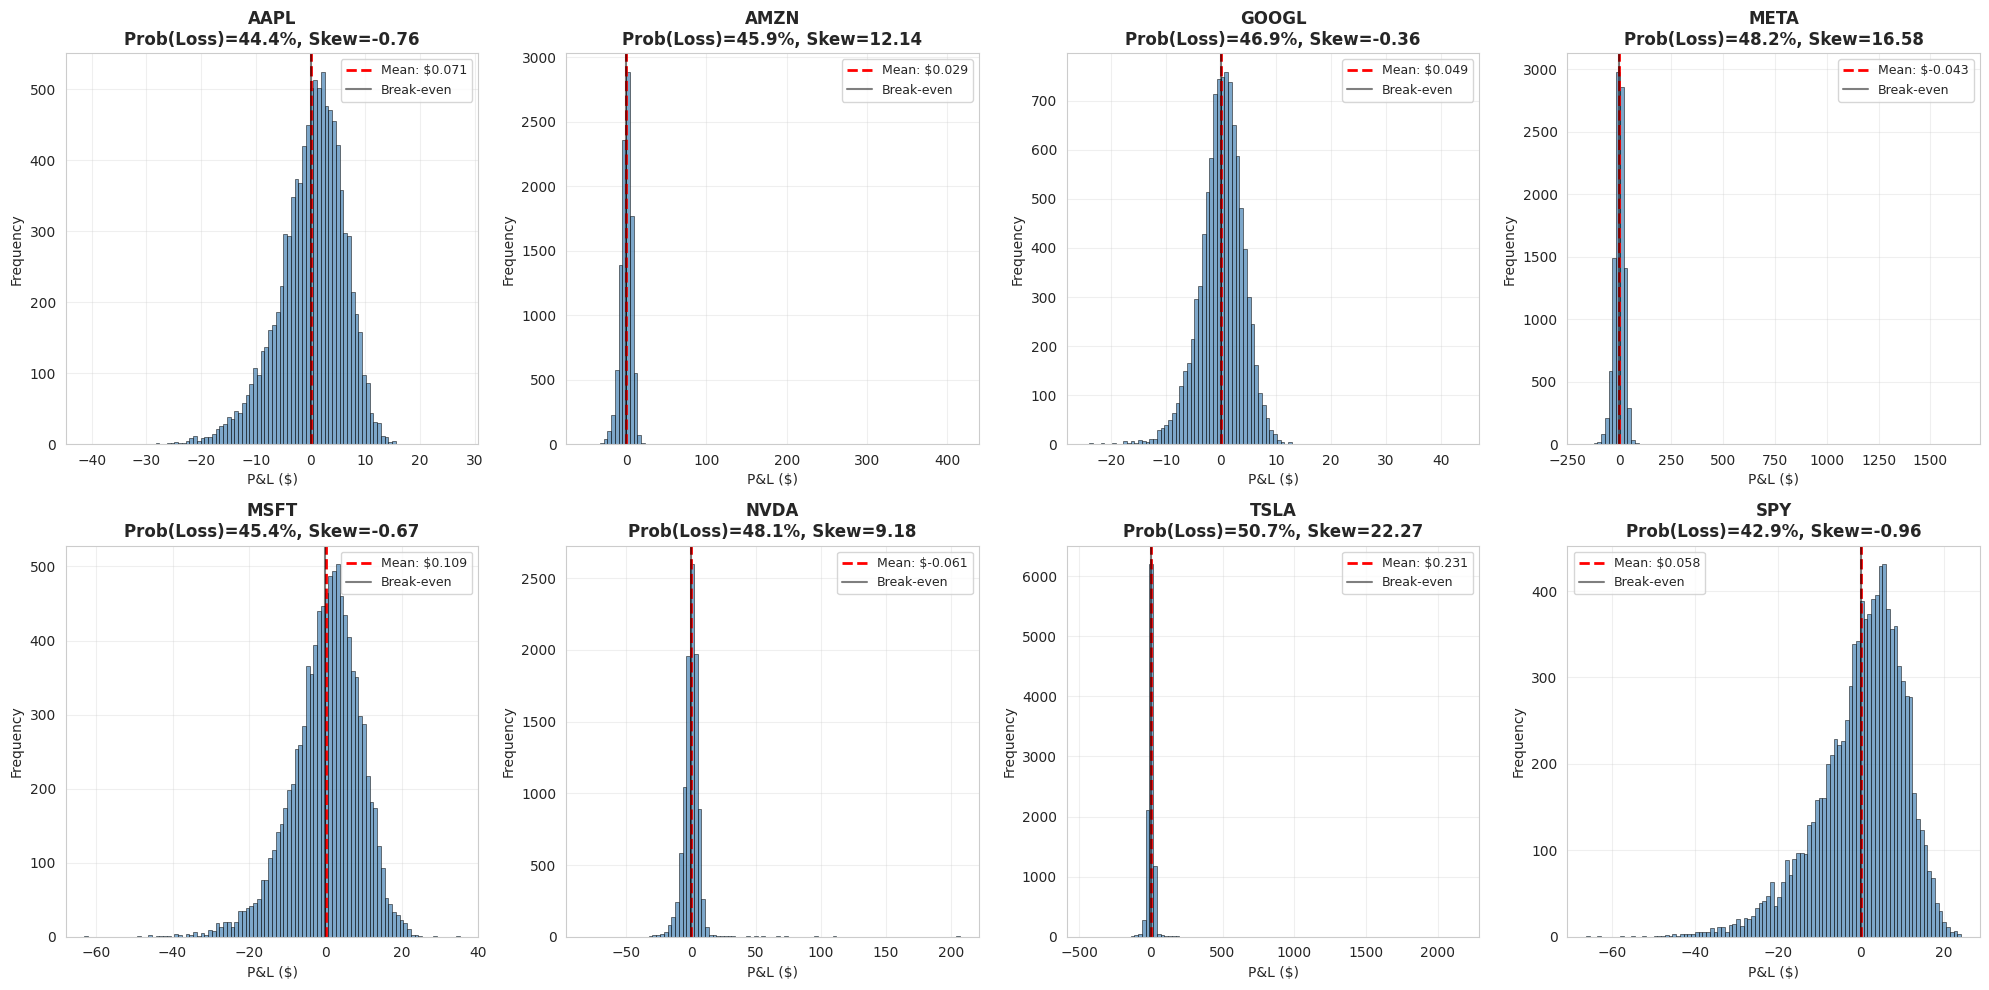

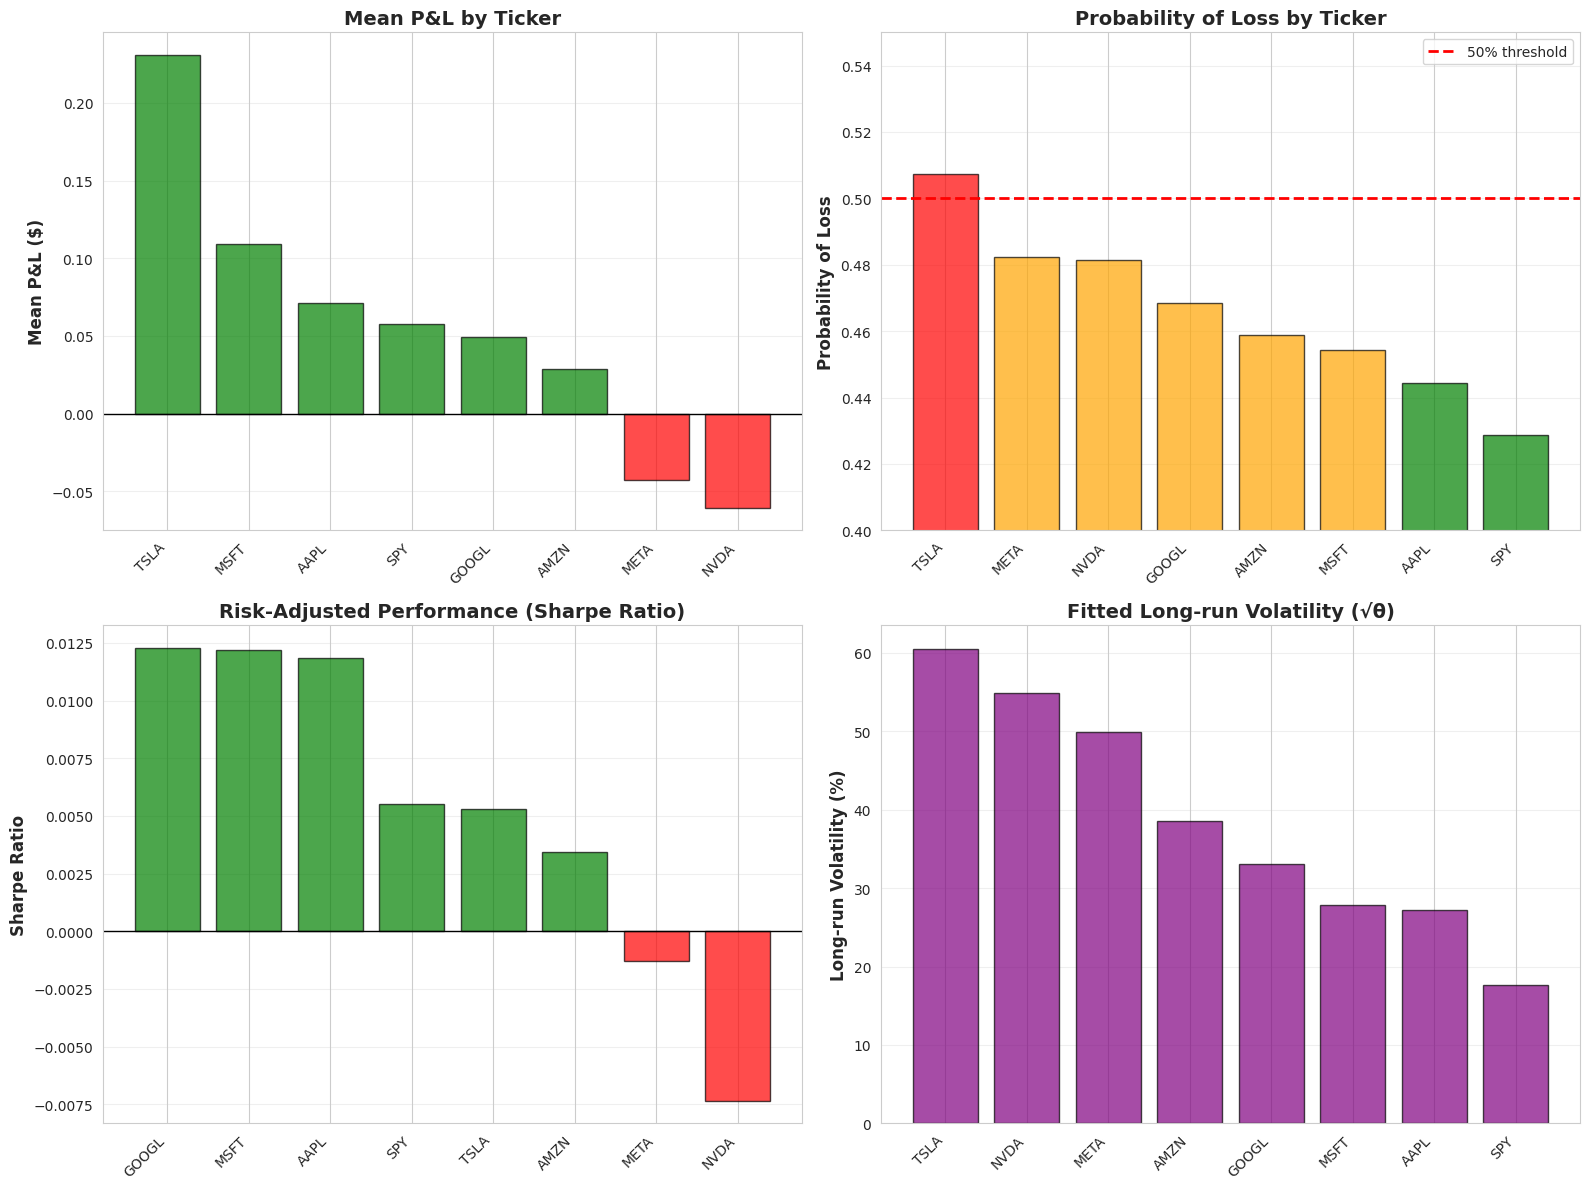

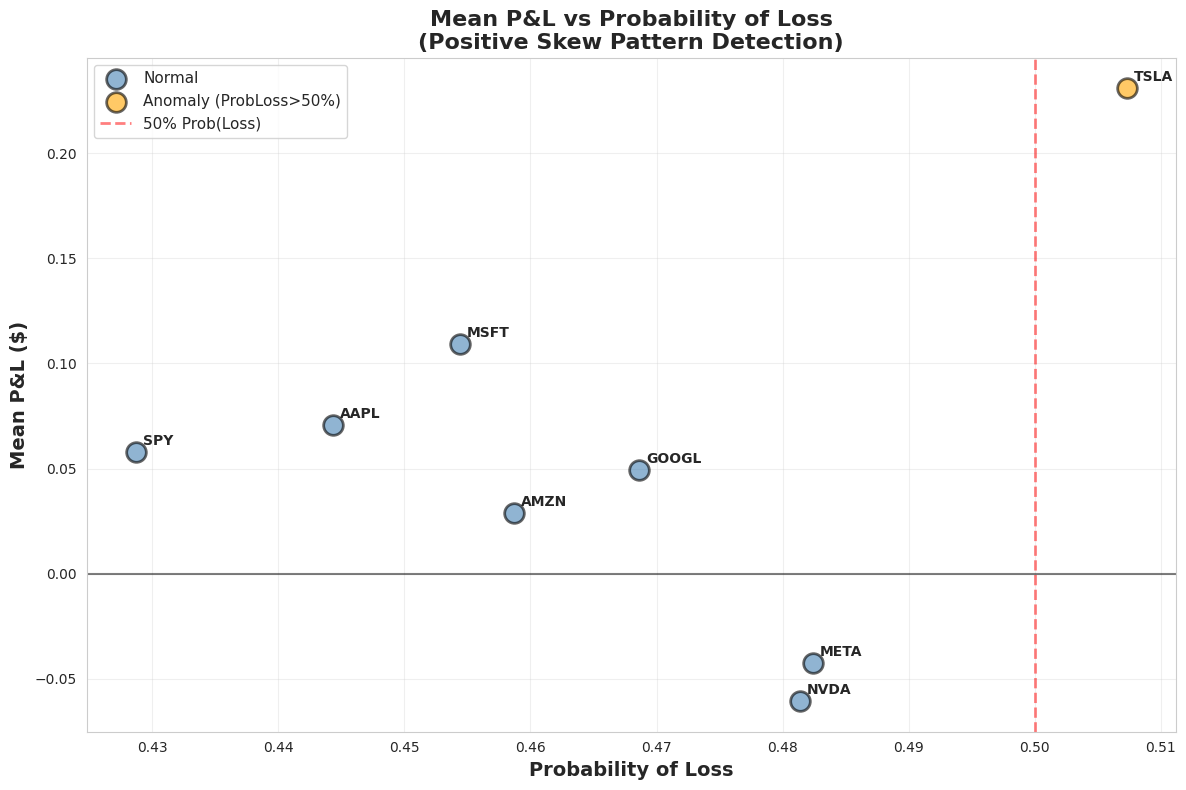

/tmp/ipython-input-3670599704.py:128: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(pnl_data, labels=tickers, patch_artist=True, showmeans=True,


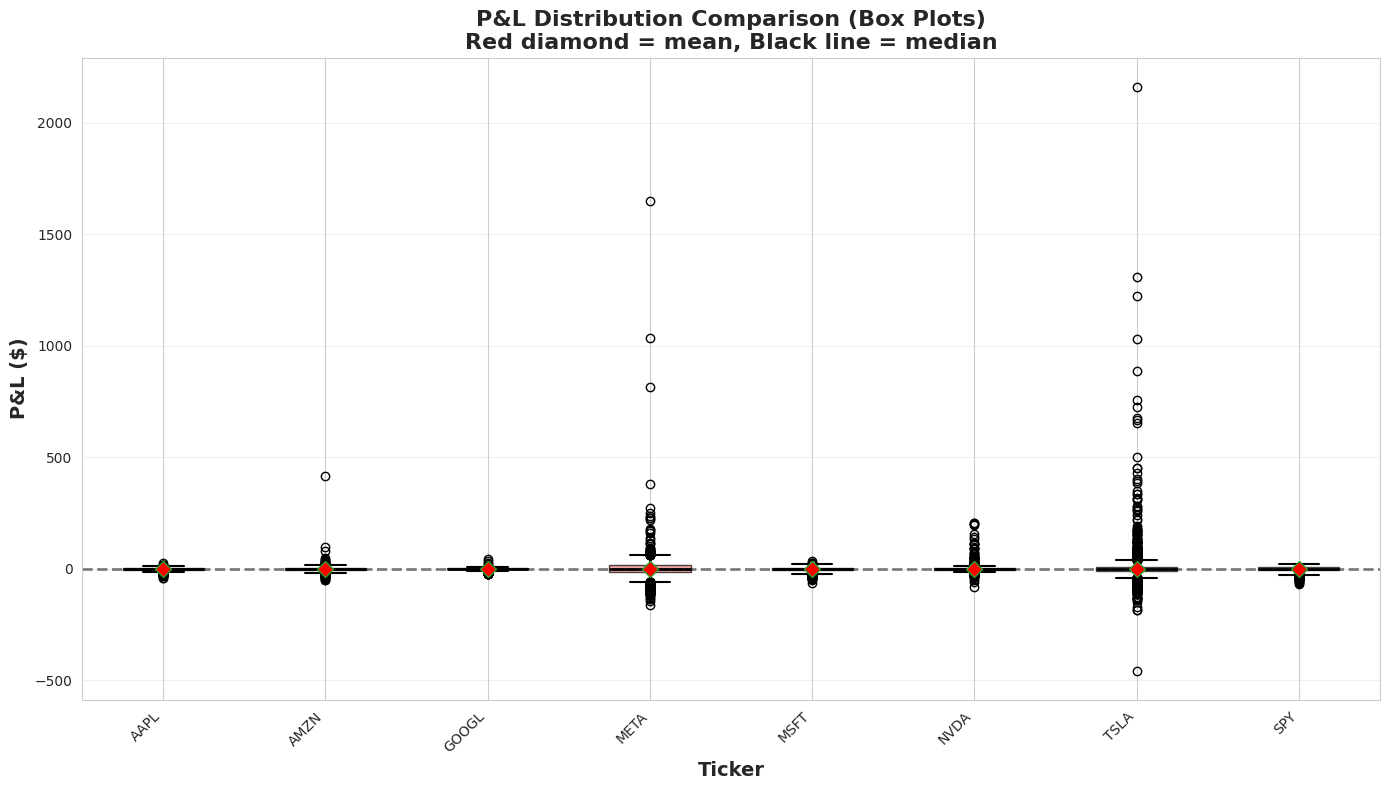

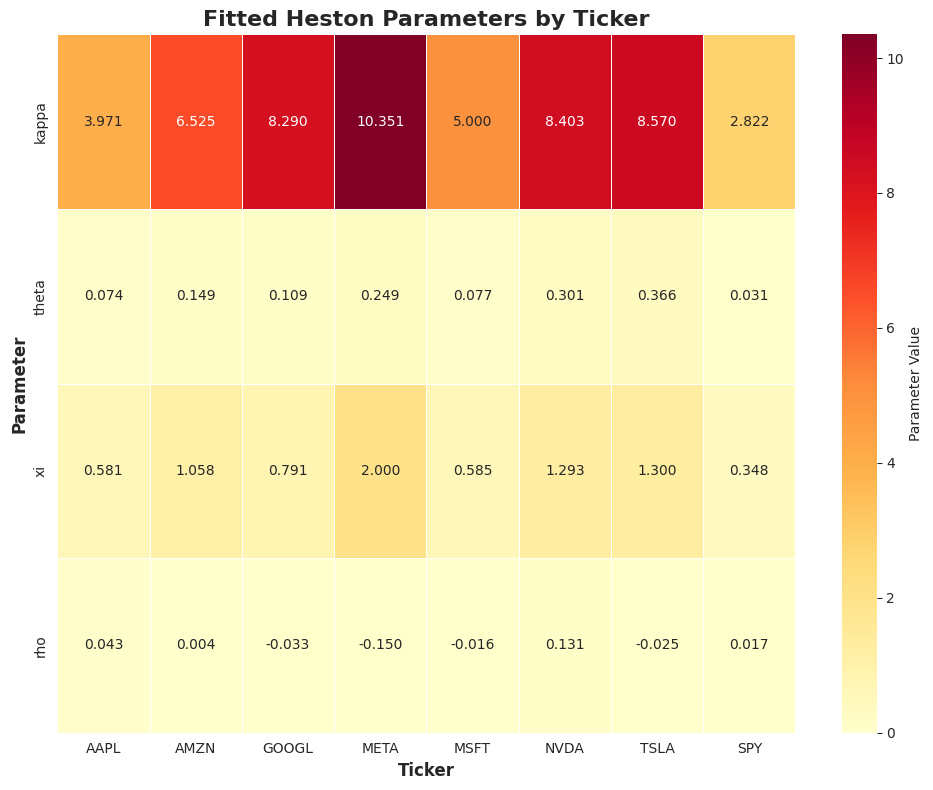

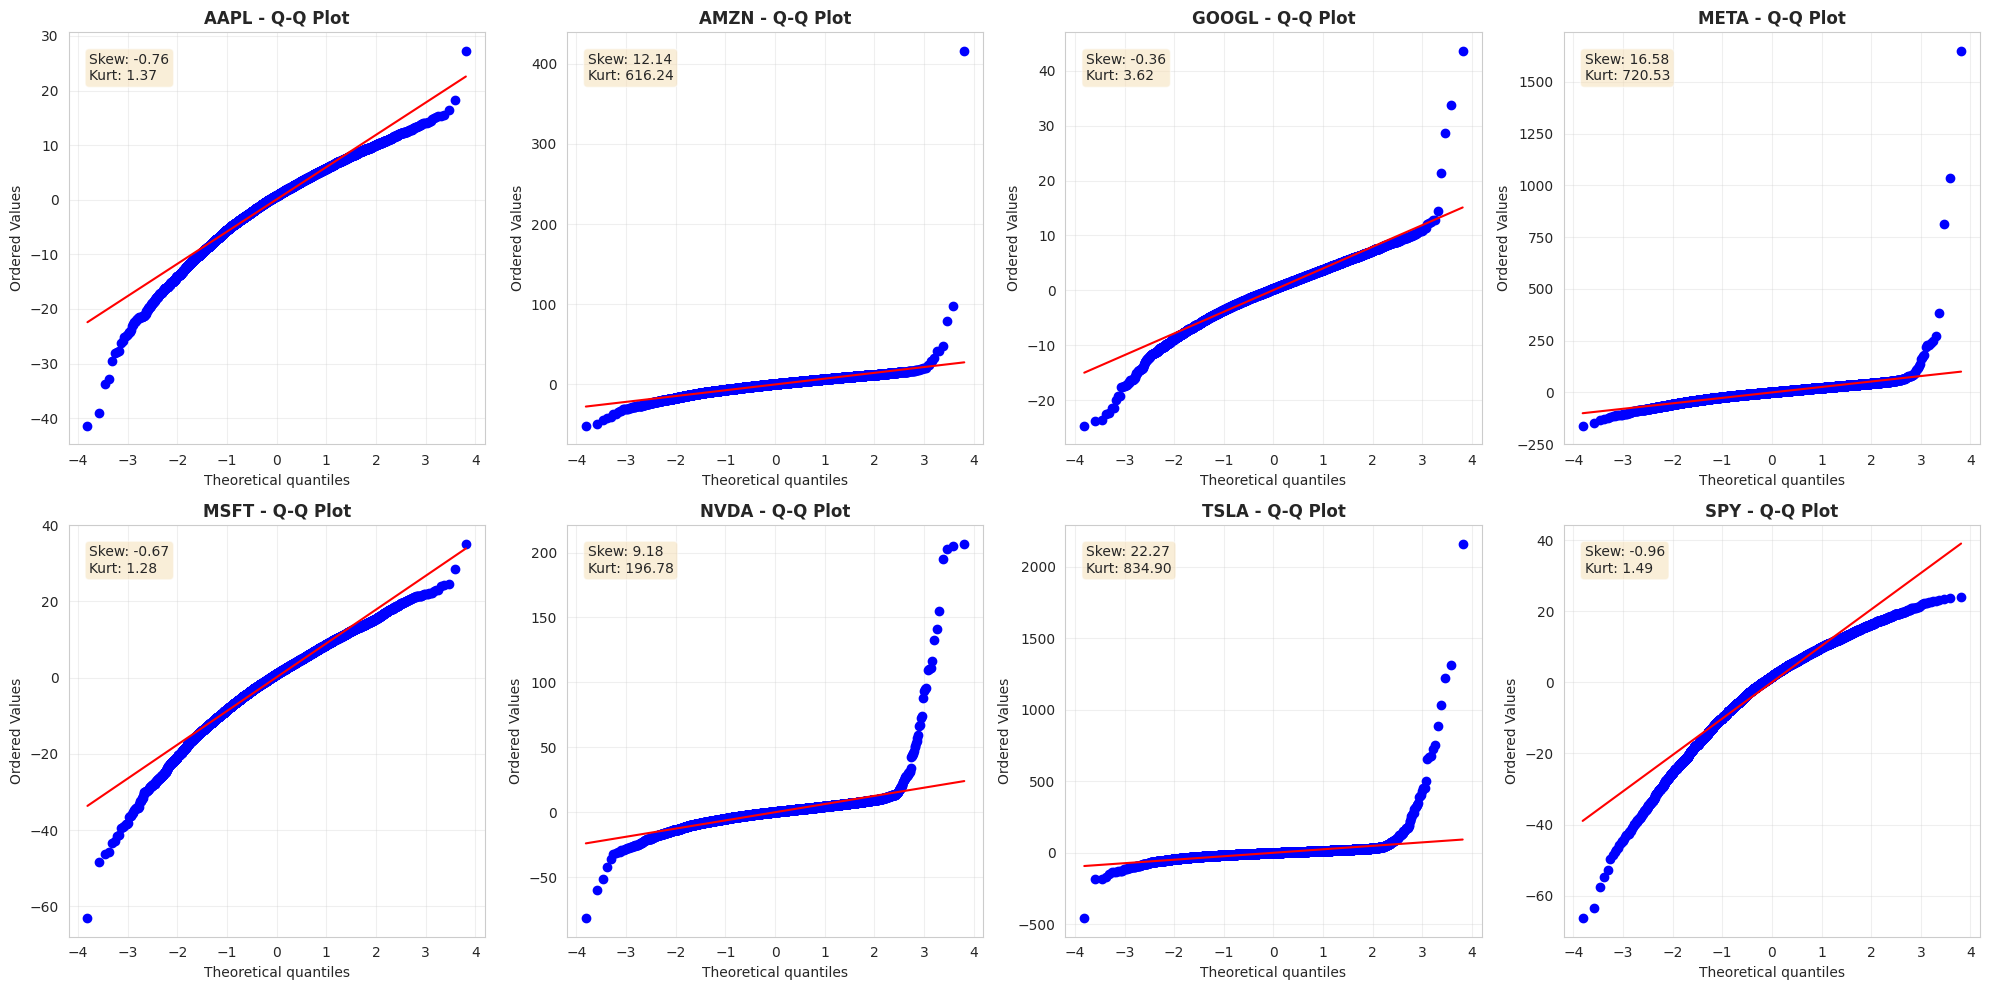


DETAILED STATISTICAL SUMMARY
          Mean  Median     Std  Skewness  Kurtosis       Min      Q25     Q75  \
Ticker                                                                          
AAPL    0.0709  0.7392  5.9871   -0.7583    1.3705  -41.3345  -3.3138  4.2000   
AMZN    0.0289  0.7083  8.3533   12.1434  616.2426  -51.1658  -4.0460  4.6817   
GOOGL   0.0492  0.2845  4.0046   -0.3614    3.6230  -24.6121  -2.2211  2.6542   
META   -0.0426  0.9063 33.4308   16.5792  720.5313 -159.7960 -14.2710 15.7377   
MSFT    0.1093  0.9704  8.9636   -0.6745    1.2808  -63.0932  -4.9873  6.1808   
NVDA   -0.0606  0.2243  8.2482    9.1818  196.7843  -81.5506  -3.0347  3.0142   
TSLA    0.2309 -0.2459 43.6395   22.2650  834.8969 -455.6999 -10.5916  8.9945   
SPY     0.0579  1.7415 10.4879   -0.9603    1.4856  -66.3006  -5.6951  7.4048   

             Max  Prob(Loss)  Sharpe    VaR95   CVaR95  
Ticker                                                  
AAPL     27.2243      0.4443  0.0118 -10.8240

In [21]:
def plot_pnl_diagnostics(df_res, pnls, tickers, save_path=None):
    sns.set_style("whitegrid")
    plt.rcParams['figure.facecolor'] = 'white'
    n_tickers = len(tickers)
    n_cols = 4
    n_rows = int(np.ceil(n_tickers / n_cols))

    fig1, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
    axes = axes.flatten() if n_tickers > 1 else [axes]

    for idx, ticker in enumerate(tickers):
        ax = axes[idx]
        pnl = pnls[ticker]
        ax.hist(pnl, bins=100, alpha=0.7, color='steelblue', edgecolor='black', linewidth=0.5)

        mean_pnl = np.mean(pnl)
        ax.axvline(mean_pnl, color='red', linestyle='--', linewidth=2, label=f'Mean: ${mean_pnl:.3f}')
        ax.axvline(0, color='black', linestyle='-', linewidth=1.5, alpha=0.5, label='Break-even')

        prob_loss = np.mean(pnl < 0)
        std_pnl = np.std(pnl)
        skewness = stats.skew(pnl)

        ax.set_title(f'{ticker}\nProb(Loss)={prob_loss:.1%}, Skew={skewness:.2f}',
                     fontsize=12, fontweight='bold')
        ax.set_xlabel('P&L ($)', fontsize=10)
        ax.set_ylabel('Frequency', fontsize=10)
        ax.legend(fontsize=9)
        ax.grid(alpha=0.3)

    for idx in range(n_tickers, len(axes)):
        axes[idx].axis('off')

    plt.tight_layout()
    if save_path:
        plt.savefig(f'{save_path}_distributions.png', dpi=300, bbox_inches='tight')
    plt.show()

    fig2, axes = plt.subplots(2, 2, figsize=(16, 12))

    sorted_by_mean = df_res.sort_values('MeanPnL', ascending=False)

    ax = axes[0, 0]
    colors = ['green' if x > 0 else 'red' for x in sorted_by_mean['MeanPnL']]
    bars = ax.bar(range(len(sorted_by_mean)), sorted_by_mean['MeanPnL'], color=colors, alpha=0.7, edgecolor='black')
    ax.set_xticks(range(len(sorted_by_mean)))
    ax.set_xticklabels(sorted_by_mean.index, rotation=45, ha='right')
    ax.axhline(0, color='black', linestyle='-', linewidth=1)
    ax.set_ylabel('Mean P&L ($)', fontsize=12, fontweight='bold')
    ax.set_title('Mean P&L by Ticker', fontsize=14, fontweight='bold')
    ax.grid(alpha=0.3, axis='y')

    ax = axes[0, 1]
    sorted_by_prob = df_res.sort_values('ProbLoss', ascending=False)
    colors = ['red' if x > 0.5 else 'orange' if x > 0.45 else 'green' for x in sorted_by_prob['ProbLoss']]
    bars = ax.bar(range(len(sorted_by_prob)), sorted_by_prob['ProbLoss'], color=colors, alpha=0.7, edgecolor='black')
    ax.set_xticks(range(len(sorted_by_prob)))
    ax.set_xticklabels(sorted_by_prob.index, rotation=45, ha='right')
    ax.axhline(0.5, color='red', linestyle='--', linewidth=2, label='50% threshold')
    ax.set_ylabel('Probability of Loss', fontsize=12, fontweight='bold')
    ax.set_title('Probability of Loss by Ticker', fontsize=14, fontweight='bold')
    ax.set_ylim([0.4, 0.55])
    ax.legend()
    ax.grid(alpha=0.3, axis='y')

    ax = axes[1, 0]
    sharpe_ratios = df_res['MeanPnL'] / df_res['StdPnL']
    sorted_by_sharpe = sharpe_ratios.sort_values(ascending=False)
    colors = ['green' if x > 0 else 'red' for x in sorted_by_sharpe]
    bars = ax.bar(range(len(sorted_by_sharpe)), sorted_by_sharpe, color=colors, alpha=0.7, edgecolor='black')
    ax.set_xticks(range(len(sorted_by_sharpe)))
    ax.set_xticklabels(sorted_by_sharpe.index, rotation=45, ha='right')
    ax.axhline(0, color='black', linestyle='-', linewidth=1)
    ax.set_ylabel('Sharpe Ratio', fontsize=12, fontweight='bold')
    ax.set_title('Risk-Adjusted Performance (Sharpe Ratio)', fontsize=14, fontweight='bold')
    ax.grid(alpha=0.3, axis='y')

    ax = axes[1, 1]
    sorted_by_theta = df_res.sort_values('theta', ascending=False)
    ann_vols = np.sqrt(sorted_by_theta['theta']) * 100  # Convert to annualized %
    bars = ax.bar(range(len(sorted_by_theta)), ann_vols, color='purple', alpha=0.7, edgecolor='black')
    ax.set_xticks(range(len(sorted_by_theta)))
    ax.set_xticklabels(sorted_by_theta.index, rotation=45, ha='right')
    ax.set_ylabel('Long-run Volatility (%)', fontsize=12, fontweight='bold')
    ax.set_title('Fitted Long-run Volatility (√θ)', fontsize=14, fontweight='bold')
    ax.grid(alpha=0.3, axis='y')

    plt.tight_layout()
    if save_path:
        plt.savefig(f'{save_path}_summary.png', dpi=300, bbox_inches='tight')
    plt.show()

    fig3, ax = plt.subplots(figsize=(12, 8))

    anomalies = (df_res['ProbLoss'] > 0.5) & (df_res['MeanPnL'] > 0)
    normal = ~anomalies

    ax.scatter(df_res.loc[normal, 'ProbLoss'], df_res.loc[normal, 'MeanPnL'],
               s=200, alpha=0.6, c='steelblue', edgecolors='black', linewidth=2, label='Normal')

    ax.scatter(df_res.loc[anomalies, 'ProbLoss'], df_res.loc[anomalies, 'MeanPnL'],
               s=200, alpha=0.6, c='orange', edgecolors='black', linewidth=2, label='Anomaly (ProbLoss>50%)')

    ax.axhline(0, color='black', linestyle='-', linewidth=1.5, alpha=0.5)
    ax.axvline(0.5, color='red', linestyle='--', linewidth=2, alpha=0.5, label='50% Prob(Loss)')

    for ticker in df_res.index:
        ax.annotate(ticker,
                   (df_res.loc[ticker, 'ProbLoss'], df_res.loc[ticker, 'MeanPnL']),
                   xytext=(5, 5), textcoords='offset points', fontsize=10, fontweight='bold')

    ax.set_xlabel('Probability of Loss', fontsize=14, fontweight='bold')
    ax.set_ylabel('Mean P&L ($)', fontsize=14, fontweight='bold')
    ax.set_title('Mean P&L vs Probability of Loss\n(Positive Skew Pattern Detection)',
                 fontsize=16, fontweight='bold')
    ax.legend(fontsize=11, loc='best')
    ax.grid(alpha=0.3)

    plt.tight_layout()
    if save_path:
        plt.savefig(f'{save_path}_scatter.png', dpi=300, bbox_inches='tight')
    plt.show()

    fig4, ax = plt.subplots(figsize=(14, 8))

    pnl_data = [pnls[ticker] for ticker in tickers]

    bp = ax.boxplot(pnl_data, labels=tickers, patch_artist=True, showmeans=True,
                    meanprops=dict(marker='D', markerfacecolor='red', markersize=8),
                    medianprops=dict(color='black', linewidth=2),
                    boxprops=dict(facecolor='lightblue', alpha=0.7),
                    whiskerprops=dict(linewidth=1.5),
                    capprops=dict(linewidth=1.5))

    for i, ticker in enumerate(tickers):
        mean_pnl = df_res.loc[ticker, 'MeanPnL']
        bp['boxes'][i].set_facecolor('lightgreen' if mean_pnl > 0 else 'lightcoral')

    ax.axhline(0, color='black', linestyle='--', linewidth=2, alpha=0.5)
    ax.set_ylabel('P&L ($)', fontsize=14, fontweight='bold')
    ax.set_xlabel('Ticker', fontsize=14, fontweight='bold')
    ax.set_title('P&L Distribution Comparison (Box Plots)\nRed diamond = mean, Black line = median',
                 fontsize=16, fontweight='bold')
    ax.grid(alpha=0.3, axis='y')
    plt.xticks(rotation=45, ha='right')

    plt.tight_layout()
    if save_path:
        plt.savefig(f'{save_path}_boxplots.png', dpi=300, bbox_inches='tight')
    plt.show()

    fig5, ax = plt.subplots(figsize=(10, 8))
    param_cols = ['kappa', 'theta', 'xi', 'rho']
    param_matrix = df_res[param_cols].T

    sns.heatmap(param_matrix, annot=True, fmt='.3f', cmap='YlOrRd',
                linewidths=0.5, cbar_kws={'label': 'Parameter Value'},
                ax=ax, vmin=0, vmax=df_res[param_cols].max().max())

    ax.set_title('Fitted Heston Parameters by Ticker', fontsize=16, fontweight='bold')
    ax.set_ylabel('Parameter', fontsize=12, fontweight='bold')
    ax.set_xlabel('Ticker', fontsize=12, fontweight='bold')

    plt.tight_layout()
    if save_path:
        plt.savefig(f'{save_path}_parameters.png', dpi=300, bbox_inches='tight')
    plt.show()

    fig6, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
    axes = axes.flatten() if n_tickers > 1 else [axes]

    for idx, ticker in enumerate(tickers):
        ax = axes[idx]
        pnl = pnls[ticker]

        stats.probplot(pnl, dist="norm", plot=ax)
        ax.set_title(f'{ticker} - Q-Q Plot', fontsize=12, fontweight='bold')
        ax.grid(alpha=0.3)

        skewness = stats.skew(pnl)
        kurtosis = stats.kurtosis(pnl)
        ax.text(0.05, 0.95, f'Skew: {skewness:.2f}\nKurt: {kurtosis:.2f}',
                transform=ax.transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
                fontsize=10)

    for idx in range(n_tickers, len(axes)):
        axes[idx].axis('off')

    plt.tight_layout()
    if save_path:
        plt.savefig(f'{save_path}_qqplots.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("\n" + "="*100)
    print("DETAILED STATISTICAL SUMMARY")
    print("="*100)

    summary_stats = []
    for ticker in tickers:
        pnl = pnls[ticker]
        stats_dict = {
            'Ticker': ticker,
            'Mean': np.mean(pnl),
            'Median': np.median(pnl),
            'Std': np.std(pnl),
            'Skewness': stats.skew(pnl),
            'Kurtosis': stats.kurtosis(pnl),
            'Min': np.min(pnl),
            'Q25': np.percentile(pnl, 25),
            'Q75': np.percentile(pnl, 75),
            'Max': np.max(pnl),
            'Prob(Loss)': np.mean(pnl < 0),
            'Sharpe': np.mean(pnl) / np.std(pnl),
            'VaR95': np.percentile(pnl, 5),
            'CVaR95': np.mean(pnl[pnl <= np.percentile(pnl, 5)])
        }
        summary_stats.append(stats_dict)

    summary_df = pd.DataFrame(summary_stats).set_index('Ticker')

    pd.options.display.float_format = '{:.4f}'.format
    print(summary_df)
    print("="*100)
    for ticker in tickers:
        prob_loss = summary_df.loc[ticker, 'Prob(Loss)']
        mean_pnl = summary_df.loc[ticker, 'Mean']
        skew = summary_df.loc[ticker, 'Skewness']

    return summary_df

summary_df = plot_pnl_diagnostics(df_res, pnls, tickers, save_path='heston_results')